In [2]:
import math
import random
from numba import cuda,jit,njit,config
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import time
import matplotlib.pyplot as plt   
import sys
import os
sys.path.append("/home/servelgar/tfg-cuda/vm/examples")
sys.path.append("/home/servelgar/tfg-cuda/vm/src")
sys.path.append("/home/servelgar/tfg-cuda/vm/tests")
print(sys.path)
from basicprobabilistic import basicprobabilistic
from spsuma import spsuma

['/home/servelgar/tfg-cuda', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/servelgar/.local/lib/python3.9/site-packages', '/usr/local/lib64/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/home/servelgar/tfg-cuda/vm/examples', '/home/servelgar/tfg-cuda/vm/src', '/home/servelgar/tfg-cuda/vm/tests', '/home/servelgar/tfg-cuda/vm/examples', '/home/servelgar/tfg-cuda/vm/src', '/home/servelgar/tfg-cuda/vm/tests']


# Table of contents
1. [Simulador basicprobabilistic](#basicprobabilistic)
    1. [Comprobación de probabilidades](#prob)
    2. [RTX 2080](#2080)
    3. [RTX 3090](#3090)
    4. [CPU JIT](#jit)
    5. [CPU](#cpunj)
2. [Simulador spsuma](#spsuma)
    1. [RTX 2080](#rtx)
    2. [RTX 3090](#rtx2)
    3. [CPU](#cpu)
    4. [CPU JIT](#cpujit)
3. [Graficas](#graficas)
    1. [basicprobabilistic](#bs)
    2. [spsuma](#sp)


# SIMULADOR BASICPROBABILISTIC <a name="basicprobabilistic"></a>


In [2]:
@cuda.jit
def kernel_computeN(array_sims,p,rng_state):
    startx, starty = cuda.grid(2)
    stridex, stridey = cuda.gridsize(2)
    
    cdf = cuda.local.array(shape=2, dtype=np.float64)
    cdf[0] = p
    cdf[1] = p + (1-p)
    index = 0
       
    for i in range(startx, array_sims.shape[0], stridex):
        for j in range(starty, array_sims.shape[1], stridey):
            idx = i * stridey + j
            rng = xoroshiro128p_uniform_float32(rng_state,idx)
            while (rng > cdf[index]):
                index = 1
            array_sims[i, j] = index
            

    
@cuda.jit
def s_reduce_sum(A,C):
    fila = cuda.grid(1)
    if fila < A.shape[0]:
        fila_sum = 0
        for j in range(A.shape[1]):
            fila_sum += A[fila,j]
        C[fila,0] = fila_sum
        C[fila,1] = A.shape[1] - fila_sum

In [3]:
@njit
def probabilistic_acum(input_matrix):
    array_media = np.zeros((n_sim,2), dtype = np.float64)
    
    for j in range(input_matrix.shape[1]):
        tmp = 0
        for i in range(input_matrix.shape[0]):
            tmp += input_matrix[i][j]
            media = tmp / ((i+1)*n)
            array_media[i][j] = media
    
    return array_media

## COMPROBAR PROBABILIDADES <a name="prob"></a>

In [4]:
########## VARIABLES #########
n = 100  # numero de viruses
n_sim = 100  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.int32)
array_sims_final = np.zeros((n_sim,2), dtype=np.int64)

############ INICIALIZACION DE HILOS, ETC #################
cuda.select_device(1)
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=1)
print(nTPB)
print(nB)

################### LAUNCH Y PRINT #####################
d_array_sims = cuda.to_device(array_sims)

kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)
d_array_final = cuda.to_device(array_sims_final)

s_reduce_sum[nB,nTPB](d_array_sims,d_array_final)

array_sims = d_array_sims.copy_to_host()
array_sims_final = d_array_final.copy_to_host()
array_medias2 = probabilistic_acum(array_sims_final)
print(array_medias2[len(array_medias2)-1])

1024
16


/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[0.5003 0.4997]


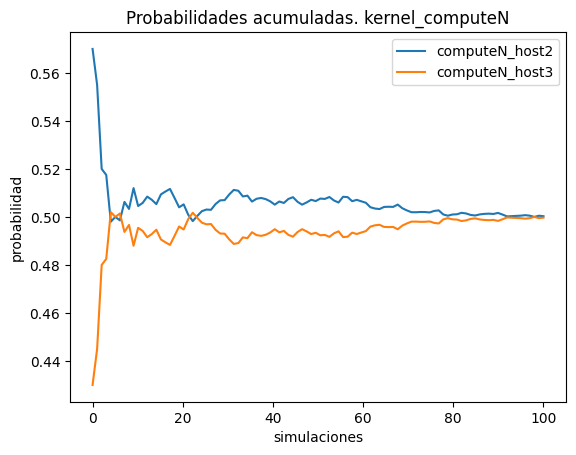

In [5]:

x = np.linspace(0,n_sim,n_sim)
y3 = array_medias2[:,0]
y4 = array_medias2[:,1]

plt.plot(x,y3, label='computeN_host2')
plt.plot(x,y4, label='computeN_host3')

plt.title("Probabilidades acumuladas. kernel_computeN")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.show()

In [15]:
########## VARIABLES #########
n = 100  # numero de viruses
n_sim = 100  # numero de simulaciones
p = 0.8 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.int32)
array_sims_final = np.zeros((n_sim,2), dtype=np.int64)

############ INICIALIZACION DE HILOS, ETC #################
cuda.select_device(1)
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=1)


################### LAUNCH Y PRINT #####################
d_array_sims = cuda.to_device(array_sims)

kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)
d_array_final = cuda.to_device(array_sims_final)

s_reduce_sum[nB,nTPB](d_array_sims,d_array_final)

array_sims = d_array_sims.copy_to_host()
array_sims_final = d_array_final.copy_to_host()
array_medias2 = probabilistic_acum(array_sims_final)
print(array_medias2[len(array_medias2)-1])

[0.1932 0.8068]


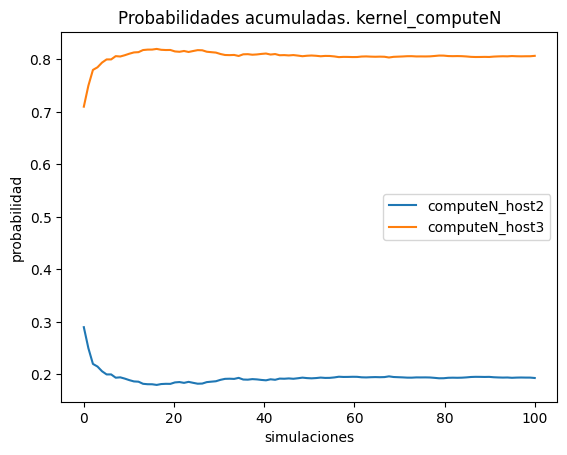

In [7]:
x = np.linspace(0,n_sim,n_sim)
y3 = array_medias2[:,0]
y4 = array_medias2[:,1]

plt.plot(x,y3, label='computeN_host2')
plt.plot(x,y4, label='computeN_host3')

plt.title("Probabilidades acumuladas. kernel_computeN")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.show()


# RTX 2080 <a name="2080"></a>

In [8]:
########## VARIABLES #########
n = 10000  # numero de viruses
n_sim = 10000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.int32)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.current_context().get_memory_info()
cuda.select_device(0)
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

In [9]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [10]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

20.3 ms ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [100]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)
blocks = math.ceil(array_sims.shape[0]/1024)

In [7]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

7 ms ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
########## VARIABLES #########
n = 5000  # numero de viruses
n_sim = 5000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(0)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

In [5]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [11]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

6.06 ms ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)
blocks = math.ceil(array_sims.shape[0]/1024)

In [7]:
#%timeit k_suma_virus_hosts[[nB,nTPB](d_array_sims, d_array_suma)

In [8]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

3.9 ms ± 6.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
########## VARIABLES #########
n = 2000  # numero de viruses
n_sim = 2000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(0)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

In [5]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [6]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

895 µs ± 271 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)

In [11]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

1.58 ms ± 55.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
########## VARIABLES #########
n = 2000  # numero de viruses
n_sim = 4000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(0)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
print(nTPB)
print(nB)
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

1024
7875


In [7]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [8]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

1.75 ms ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)

In [12]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

1.61 ms ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# RTX 3090 <a name="3090"></a>

In [20]:
########## VARIABLES #########
n = 10000  # numero de viruses
n_sim = 10000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(1)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

In [21]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [11]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

16.3 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)
blocks = math.ceil(array_sims.shape[0]/1024)

In [23]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

5.29 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
########## VARIABLES #########
n = 5000  # numero de viruses
n_sim = 5000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(1)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

In [15]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [16]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

4.03 ms ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)
blocks = math.ceil(array_sims.shape[0]/1024)

In [19]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

2.07 ms ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
########## VARIABLES #########
n = 2000  # numero de viruses
n_sim = 4000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(1)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
print(nTPB)
print(nB)
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

1024
3969


In [21]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [22]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

1.25 ms ± 6.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)

In [26]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

1.07 ms ± 3.12 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
########## VARIABLES #########
n = 2000  # numero de viruses
n_sim = 2000  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.float64)
array_suma = np.zeros((n_sim,2), dtype=np.int64)
cuda.select_device(1)
#print(cuda.current_context().get_memory_info())
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
print(nTPB)
print(nB)
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=time.time())

1024
16


In [9]:
d_array_sims = cuda.to_device(array_sims)
d_array_suma = cuda.to_device(array_suma)

In [10]:
%timeit kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)

621 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p,rng_states)

In [14]:
%timeit s_reduce_sum[nB,nTPB](d_array_sims, d_array_suma)

1.06 ms ± 2.01 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## CPU JIT <a name="jit"></a>

In [4]:
@njit
def cpu_simulaciones(n,p,array_sims):
    
    cdf = np.array([p,(p+(1-p))])
    
    for i in range(array_sims.shape[0]):
        for j in range(n):
            array_sims[i][0] -= 1
            rnd = random.random()
            index = 0
            while rnd > cdf[index]:
                index += 1
            array_sims[i][index+1] += 1
    
    return array_sims

In [5]:
n_sims = 10000  # numero de computaciones de maquinas virus

n = 10000  #número de virus
p = 0.5  #probabilidad

array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

In [6]:
%timeit cpu_simulaciones(n,p,array_sims)

950 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
n_sims = 5000  # numero de computaciones de maquinas virus

n = 5000  #número de virus
p = 0.5  #probabilidad

array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

In [8]:
%timeit cpu_simulaciones(n,p,array_sims)

242 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
n_sims = 2000  # numero de computaciones de maquinas virus

n = 4000  #número de virus
p = 0.5  #probabilidad

array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

In [10]:
%timeit cpu_simulaciones(n,p,array_sims)

75.2 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
n_sims = 2000  # numero de computaciones de maquinas virus
n = 2000  #número de virus
p = 0.5  #probabilidad

array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

In [12]:
%timeit cpu_simulaciones(n,p,array_sims)

38.1 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## CPU <a name="cpunj"></a>

In [8]:
def cpu_simulaciones_sinJIT(n_sims, n, p):
    i = 0
    vm = basicprobabilistic(n, p)
    l_prob = [[0,0]]
    while i < n_sims:
        (uh, lista_compute) = vm.compute()
        p1 = lista_compute[1] 
        p2 = lista_compute[2] 
        l_prob.append([p1, p2])
        i += 1
        vm.restart()
    l_prob.pop(0)
    return l_prob

In [9]:
n_sims = 2000  # numero de computaciones de maquinas virus
n = 2000  #número de virus
p = 0.5  #probabilidad
%timeit cpu_simulaciones_sinJIT(n_sims,n,p)  

9.79 s ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
n_sims = 2000  # numero de computaciones de maquinas virus

n = 4000  #número de virus
p = 0.5  #probabilidad
%timeit cpu_simulaciones_sinJIT(n_sims,n,p)  

19.8 s ± 76.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
n_sims = 5000  # numero de computaciones de maquinas virus

n = 5000  #número de virus
p = 0.5  #probabilidad
%timeit cpu_simulaciones_sinJIT(n_sims,n,p) 

1min 1s ± 365 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
n_sims = 10000  # numero de computaciones de maquinas virus

n = 10000  #número de virus
p = 0.5  #probabilidad
%timeit cpu_simulaciones_sinJIT(n_sims,n,p) 

4min 2s ± 612 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# SPSUMA <a name="spsuma"></a>

In [3]:
@cuda.jit
def kernel_compute(array_comp, initial_instructions):
    x = cuda.threadIdx.x
    columna = cuda.blockDim.x * cuda.blockIdx.x + x
    
    # recorrer la matriz a mano, paralelización por cada step.
    for i in range(1, array_comp.shape[0]):
        if(array_comp[i-1][0] != 0 and array_comp[i-1][1] != 0):
            if (columna < initial_instructions.shape[0]):   
                array_comp[i][columna] = array_comp[i-1][columna] - 1
                array_comp[i][2] = array_comp[i-1][2] + initial_instructions.shape[0] # sin pesos, voy a sumar la cantidad de instrucciones que se activen
                array_comp[i][3] = 2
        elif(array_comp[i-1][0] == 0 and array_comp[i-1][1] == 0):
            sol = array_comp[i-1][2]
            if (columna < array_comp.shape[0] - i):
                array_comp[columna + i][2] = sol
                array_comp[columna + i][3] = -1
        else:
            # mono instrucción por step:
            if (array_comp[i-1][0] == 0 and array_comp[i-1][1] != 0):
                array_comp[i][1] = array_comp[i-1][1] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 1
            
            elif(array_comp[i-1][1] == 0 and array_comp[i-1][0] != 0):
                array_comp[i][0] = array_comp[i-1][0] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 0
        cuda.syncthreads()

## RTX 2080 <a name="rtx"></a>

In [34]:
n1 = 50
n2 = 50
n_steps = 100
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [35]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

45.6 µs ± 0.363 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
n1 = 100
n2 = 100
n_steps = 200
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [37]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

90.4 µs ± 5.54 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [38]:
n1 = 500
n2 = 500
n_steps =1000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [39]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

542 µs ± 7.51 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
n1 = 2000
n2 = 2000
n_steps = 4000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [41]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

3.46 ms ± 462 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
n1 = 5000
n2 = 5000
n_steps = 10000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [43]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

9.72 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
n1 = 10000
n2 = 10000
n_steps = 20000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [45]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

20.2 ms ± 122 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
n1 = 30000
n2 = 30000
n_steps = 60000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = math.ceil(array_comp.shape[0] / threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

66.9 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
n1 = 40000
n2 = 40000
n_steps = 80000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

84.9 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [46]:
n1 = 50000
n2 = 50000
n_steps = 100000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(0)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [47]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

104 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## RTX 3090 <a name="rtx2"></a>

In [43]:
n1 = 50
n2 = 50
n_steps = 100
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((array_comp.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [44]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


33.7 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
n1 = 100
n2 = 100
n_steps = 200
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [7]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

79 µs ± 0.666 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
n1 = 500
n2 = 500
n_steps =1000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [9]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

460 µs ± 938 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
n1 = 2000
n2 = 2000
n_steps = 4000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [11]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

3.24 ms ± 165 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
n1 = 5000
n2 = 5000
n_steps = 10000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [13]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

9.07 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
n1 = 10000
n2 = 10000
n_steps = 20000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [15]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

18.8 ms ± 7.83 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
n1 = 30000
n2 = 30000
n_steps = 60000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)
%timeit -r 7 -n 1000 kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

The slowest run took 1586.51 times longer than the fastest. This could mean that an intermediate result is being cached.
49.3 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
n1 = 40000
n2 = 40000
n_steps = 80000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

77.4 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
n1 = 50000
n2 = 50000
n_steps = 100000
initial_instructions = np.array([0, 1]) 
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
cuda.select_device(1)
threads_per_block = 1024
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [17]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

97.3 ms ± 367 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# CPU <a name="cpu"></a>

In [18]:
def compute(n1,n2):
    vm = spsuma(n1,n2)
    vm.compute()
    vm.restart()

In [4]:
n1 = 100
n2 = 100
vm = spsuma(n1,n2)
%timeit compute(n1,n2)

530 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
n1 = 500
n2 = 500
%timeit compute(n1,n2)

2.46 ms ± 7.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
n1 = 2000
n2 = 2000
%timeit compute(n1,n2)

9.79 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
n1 = 5000
n2 = 5000
%timeit compute(n1,n2)

24.4 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
n1 = 10000
n2 = 10000
%timeit compute(n1,n2)

48.8 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
n1 = 30000
n2 = 30000
%timeit compute(n1,n2)

149 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
n1 = 40000
n2 = 40000
%timeit compute(n1,n2)

203 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
n1 = 50000
n2 = 50000
%timeit compute(n1,n2)

243 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CPU JIT <a name="cpujit"></a>

In [5]:
@njit
def spsumaJIT(array_comp, initial_instructions):
    for i in range(1, array_comp.shape[0]):
        if(array_comp[i-1][0] != 0 and array_comp[i-1][1] != 0):
            for j in range(initial_instructions.shape[0]):   
                array_comp[i][j] = array_comp[i-1][j] - 1
                array_comp[i][2] = array_comp[i-1][2] + initial_instructions.shape[0] # sin pesos, voy a sumar la cantidad de instrucciones que se activen
                array_comp[i][3] = 2
        elif(array_comp[i-1][0] == 0 and array_comp[i-1][1] == 0):
            sol = array_comp[i-1][2]
            for j in range(array_comp.shape[0] - i):
                array_comp[j + i][2] = sol
                array_comp[j + i][3] = -1
        else:
            # mono instrucción por step:
            if (array_comp[i-1][0] == 0 and array_comp[i-1][1] != 0):
                array_comp[i][1] = array_comp[i-1][1] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 1
            
            elif(array_comp[i-1][1] == 0 and array_comp[i-1][0] != 0):
                array_comp[i][0] = array_comp[i-1][0] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 0
    
    return array_comp

In [6]:
n1 = 100
n2 = 100
n_steps =200
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

5.81 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
n1 = 500
n2 = 500
n_steps =1000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

80.8 µs ± 159 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
n1 = 2000
n2 = 2000
n_steps =4000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

1.27 ms ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
n1 = 5000
n2 = 5000
n_steps =10000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

7.95 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
n1 = 10000
n2 = 10000
n_steps =20000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

33.2 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
n1 = 30000
n2 = 30000
n_steps =60000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

314 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
n1 = 40000
n2 = 40000
n_steps =80000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit spsumaJIT(array_comp,initial_instructions)

590 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
n1 = 50000
n2 = 50000
n_steps =100000
initial_instructions = np.zeros((2,),dtype=np.int64) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)
array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2
%timeit -r 4 -n 100 spsumaJIT(array_comp,initial_instructions)

908 ms ± 3.18 ms per loop (mean ± std. dev. of 4 runs, 100 loops each)


# GRAFICAS <a name="graficas"></a>

## basicprobabilistic <a name="bs"></a>

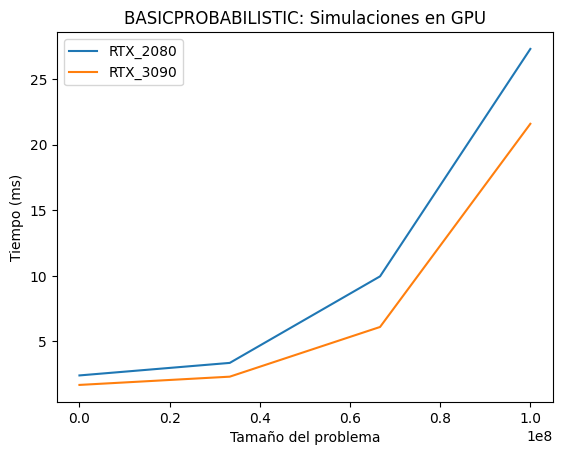

In [23]:
#REGISTRO DE TIEMPOS (en ms)
t_RTX_2080_100M = 20.3 + 7
t_RTX_3090_100M= 16.3  + 5.29
t_RTX_2080_25M = 6.06 + 3.9
t_RTX_3090_25M = 4.03 + 2.07
t_RTX_3090_4M = 0.621 + 1.06
t_RTX_2080_4M = 0.825 + 1.58
t_RTX_3090_8M = 1.06 + 1.25
t_RTX_2080_8M = 1.75 + 1.61



y1 = [t_RTX_2080_4M,t_RTX_2080_8M, t_RTX_2080_25M, t_RTX_2080_100M]
y2 = [t_RTX_3090_4M,t_RTX_3090_8M, t_RTX_3090_25M,t_RTX_3090_100M]
maximo = max(y1+y2)
x = np.linspace(0,100000000,len(y1))

plt.plot(x,y1, label='RTX_2080')
plt.plot(x,y2, label='RTX_3090')


plt.title("BASICPROBABILISTIC: Simulaciones en GPU")
plt.xlabel("Tamaño del problema")
plt.ylabel("Tiempo (ms)")
plt.legend()

plt.show()


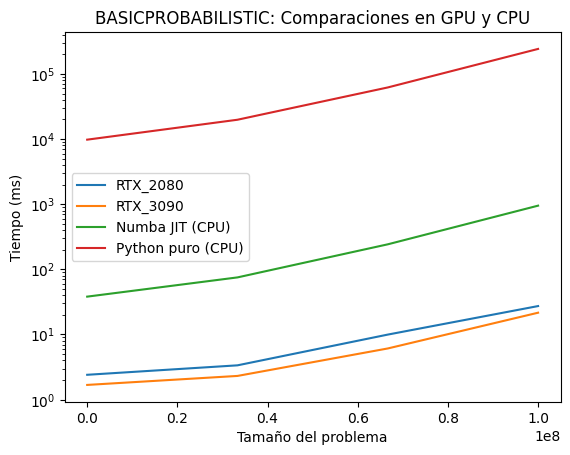

In [13]:
t_CPU_JIT_4M = 38.1
t_CPU_JIT_8M = 75.2
t_CPU_JIT_25M = 242.2 
t_CPU_JIT_100M = 950

t_CPU_4M = 9.79 * 1000
t_CPU_8M = 19.8 * 1000
t_CPU_25M = 62 * 1000
t_CPU_100M = 242 * 1000


y3 = [t_CPU_JIT_4M,t_CPU_JIT_8M,t_CPU_JIT_25M,t_CPU_JIT_100M]
y4 = [t_CPU_4M, t_CPU_8M, t_CPU_25M, t_CPU_100M]

x = np.linspace(0,100000000,len(y1))

plt.plot(x,y1, label='RTX_2080')
plt.plot(x,y2, label='RTX_3090')
plt.plot(x,y3, label='Numba JIT (CPU)')
plt.plot(x,y4, label='Python puro (CPU)')
plt.yscale('log')

plt.title("BASICPROBABILISTIC: Comparaciones en GPU y CPU")
plt.xlabel("Tamaño del problema")
plt.ylabel("Tiempo (ms)")
plt.legend()

plt.show()

## spsuma <a name="sp"></a>


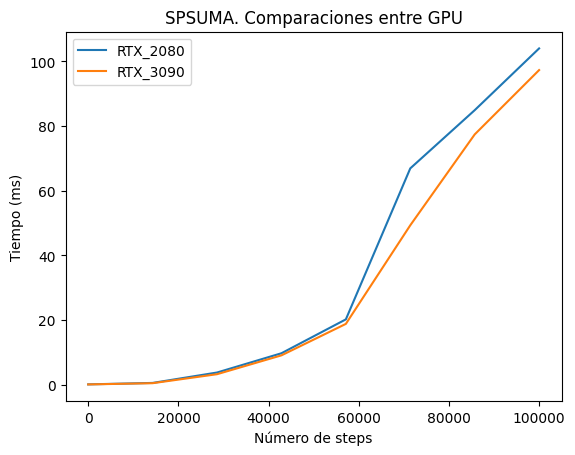

In [6]:
t_RTX_2080_100K = 104
t_RTX_2080_80K = 84.9
t_RTX_2080_60K = 66.9
t_RTX_2080_20K = 20.2
t_RTX_2080_10K = 9.72
t_RTX_2080_4K = 3.76
t_RTX_2080_1K = 0.542
t_RTX_2080_200 = 0.09

t_RTX_3090_100K = 97.3
t_RTX_3090_80K = 77.4
t_RTX_3090_60K = 49.3
t_RTX_3090_20K = 18.8
t_RTX_3090_10K = 9.07
t_RTX_3090_4K = 3.24
t_RTX_3090_1K = 0.460
t_RTX_3090_200 = 0.079

y1 = [t_RTX_2080_200,t_RTX_2080_1K, t_RTX_2080_4K, t_RTX_2080_10K, t_RTX_2080_20K, t_RTX_2080_60K, t_RTX_2080_80K, t_RTX_2080_100K]
y2 = [t_RTX_3090_200,t_RTX_3090_1K, t_RTX_3090_4K,t_RTX_3090_10K, t_RTX_3090_20K, t_RTX_3090_60K, t_RTX_3090_80K, t_RTX_3090_100K]
maximo = max(y1+y2)
x = np.linspace(0,100_000,len(y1))

plt.plot(x,y1, label='RTX_2080')
plt.plot(x,y2, label='RTX_3090')


plt.title("SPSUMA. Comparaciones entre GPU")
plt.xlabel("Número de steps")
plt.ylabel("Tiempo (ms)")
plt.legend()

plt.show()

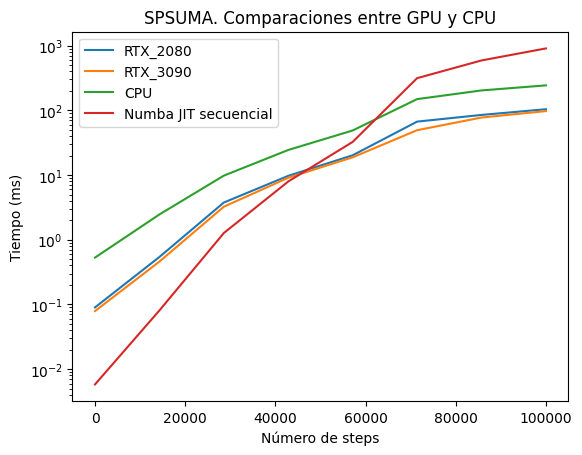

In [9]:
t_CPU_200 = 0.530
t_CPU_1k = 2.46
t_CPU_4k = 9.79
t_CPU_10k = 24.4
t_CPU_20k = 48.8
t_CPU_60k = 149
t_CPU_80k = 203
t_CPU_100k = 243

t_CPU_JIT_200 = 5.81/1000
t_CPU_JIT_1k = 80.8/1000
t_CPU_JIT_4k = 1.27
t_CPU_JIT_10k = 7.95
t_CPU_JIT_20k = 32.5
t_CPU_JIT_60k = 314
t_CPU_JIT_80k = 590
t_CPU_JIT_100k = 905


y3 = [t_CPU_200, t_CPU_1k, t_CPU_4k, t_CPU_10k, t_CPU_20k, t_CPU_60k, t_CPU_80k, t_CPU_100k]
y4 = [t_CPU_JIT_200, t_CPU_JIT_1k, t_CPU_JIT_4k, t_CPU_JIT_10k, t_CPU_JIT_20k, t_CPU_JIT_60k, t_CPU_JIT_80k, t_CPU_JIT_100k]
x = np.linspace(0,100_000,len(y1))

plt.plot(x,y1, label='RTX_2080')
plt.plot(x,y2, label='RTX_3090')
plt.plot(x,y3, label='CPU')
plt.plot(x,y4, label='Numba JIT secuencial')

plt.yscale('log')

plt.title("SPSUMA. Comparaciones entre GPU y CPU")
plt.xlabel("Número de steps")
plt.ylabel("Tiempo (ms)")
plt.legend()

plt.show()



6.07 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


<CUDA device 1 'b'NVIDIA GeForce RTX 2080''>


6.74 ms ± 9.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
